# Data Processing - TRKR

## Notes on this notebook

In [1]:
# run using dev install of EDA:
# github.com/vsihlab/eda
# commit ID: [TODO, downstream from v0.1.1]

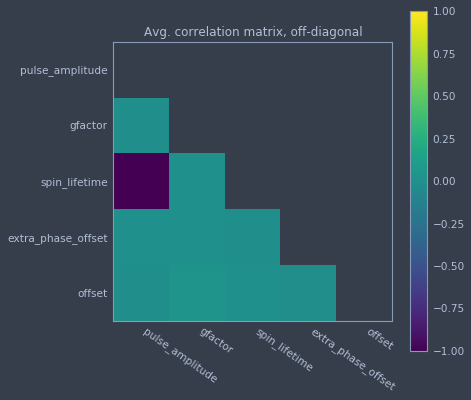

In [2]:
from IPython.display import Image
display(Image(".//img_for_notes.png"))

## Imports and global variables

In [3]:
# General imports
import json
import pickle

from IPython.display import display
from lmfit import report_fit
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import eda.analysis.dataframe_plotting as dfplot
import eda.data_io.csv_to_dataframe as csv2df

In [4]:
# GLOBAL UNITS: 
# time: ps
# b-field: mT
# voltages: V

# FIGURE DIMENSIONS FOR PRIVATE USE VS REPO:
# FIG_SIZE_MULT = 4  # normal use
FIG_SIZE_MULT = 2.5  # smaller version for repo notebooks

FONT_SCALE = FIG_SIZE_MULT / 2.5

In [5]:
# Optional: import jtplot to make figures match jupyterthemes config
import importlib
jtplot_found = importlib.util.find_spec("jupyterthemes.jtplot") is not None
if jtplot_found:
    from jupyterthemes import jtplot
    # - currently installed theme will be used to
    jtplot.style(ticks=False, grid=False, fscale=FONT_SCALE)
    # set the default figure size
    jtplot.figsize(x=FIG_SIZE_MULT * 2.5, y=FIG_SIZE_MULT * 2.5)
    # needed to avoid spurious error messages with imshow...
    import warnings
    warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

## Load and process data

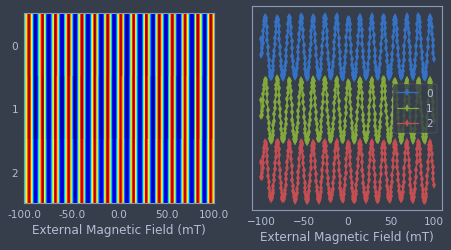

lockin1  kerr_rotation  file_index  probe_delay  \
run_id index_2d index_1d                                                     
0      0.0      0         0.000266        0.01572           0       -160.0   
                1         0.000213       -0.00434           0       -160.0   
                2         0.000274       -0.00180           0       -160.0   
                3         0.000351        0.00418           0       -160.0   
                4         0.000342        0.01082           0       -160.0   

                          wavelength  b_external  
run_id index_2d index_1d                          
0      0.0      0              836.0      -100.0  
                1              836.0       -99.5  
                2              836.0       -99.0  
                3              836.0       -98.5  
                4              836.0       -98.0

In [6]:
# REQUIRED: columns & labels used to plot data.
# may be present in the raw data or defined somewhere
# below. If column is renamed below, this variable
# will also be updated to reflect the new name.
scan_coordinate_column = "Magnetic Field (T)"
measured_value_column = "kerr_rotation"
scan_coordinate_label = "External Magnetic Field (mT)"

# REQUIRED: output filenames
output_dataframe_filename = "processed_dataframe.csv"
output_metadata_list_filename = "processed_metadata_list.json"
output_image_filename = "processed_dataframe_plot.png"

# REQUIRED: data directory
parent_dir = ('.')

# REQUIRED: data storage format information
delimiter = '\t'
trailing_delimiters = True  # rows end in delimiters
num_headerlines = 0
column_names_row = 1  # NOT counting skipped lines from num_headerlines
overwriting_column_names = []

if not overwriting_column_names:
    overwriting_column_names = None
pandas_read_csv_kwargs = {
     'skiprows': num_headerlines,
     'header': column_names_row,
     'names': overwriting_column_names,
     'delimiter': delimiter,
}
if trailing_delimiters:  # needed to avoid problems
    pandas_read_csv_kwargs['index_col'] = False

# REQUIRED: filename key for data files, will load only these
filename_key = '.dat'

# REQUIRED: criteria for grouping runs
run_criteria = 'directory'

# OPTIONAL: filepath parsing rules
# DEFAULT SEARCH TERMS AND SEARCH RULES:
# 1. If first string found, register second string as
#    tag containing third string/value
#        e.g. if keyword_list contains ("warmup", "Warmup?", "Yes"):
#             "...warmup..." -> {"Warmup?": "Yes"}
this_element_keyword_list = [
    (       "CISP", "Experiment Type", "CISP"       ),
    ( "Delay_Scan", "Experiment Type", "Delay_Scan" ),
    ( "Field_Scan", "Experiment Type", "Field_Scan" ),
    ("Mirror_Scan", "Experiment Type", "Mirror_Scan"),
    ( "RMBE1130-K", "Sample ID", "RMBE1130-K"),
    ("[1-10]Horiz", "Sample Orientation", "[1-10]Horiz"),
]
# 2. Grab next element(s) if this one CONTAINS first string,
#    tag next element(s) as second string(s)
#        e.g. "..._Ind_3_..." -> {"FastScanIndex": 3}
#        e.g. "..._2Dscan_MirrorY_MirrorZ_..."
#                 -> {"SecondScanType": "MirrorY",
#                     "FirstScanType": "MirrorZ"}
next_element_keyword_list = []
# 3. Grab this element if it CONTAINS first string,
#    tag remainder as second string
#        e.g. "..._30K_..." -> {"SetTemperature": 30}
in_this_element_keyword_list = [
    ("FIELD", "Date_and_Scan_2D_Index"),
    ("DLAY", "Date_and_Scan_2D_Index"),
    ("STPR", "Date_and_Scan_2D_Index"),
    ("phi-", "Electric Field Angle"),
    ("T", "Magnetic Field (T)"),
    ("K", "Set Temperature (K)"),
    ("nm", "Wavelength (nm)"),
    ("ps", "Delay Time (ps)"),
    ("V", "Voltage (V)"),
]
parsing_keyword_lists = [this_element_keyword_list,
                         next_element_keyword_list,
                         in_this_element_keyword_list]

# OPTIONAL: metadata processing functions,
# must accept dict and modify in-place
def derive_metadata_from_scan_type_tag(metadata_dict):
    if 'Date_and_Scan_2D_Index' in metadata_dict.keys():
        date_and_index = str(metadata_dict['Date_and_Scan_2D_Index'])
        metadata_dict['Date'] = date_and_index[:6]
        metadata_dict['Scan_2D_Index'] = float(date_and_index[6:]) - 1
        del metadata_dict['Date_and_Scan_2D_Index']
#     # not needed for field scan: magnetic field is col, not metadata
#     def consolidate_aliases_for_bfield(metadata_dict):
#         if 'Magnetic Field (T)' in metadata_dict.keys():
#             metadata_dict['Magnetic Field (mT)'] = \
#                 1000.0 * metadata_dict['Magnetic Field (T)']
#             del metadata_dict['Magnetic Field (T)']
metadata_processing_fcns = [derive_metadata_from_scan_type_tag]

# OPTIONAL: metadata-based filtering fcns, type: dict() -> bool
# fcns returning False if data should be ignored
metadata_filter_fcns = [
    lambda metadata_dict: \
        "alignment" not in metadata_dict.get("Filepath"),
#     lambda metadata_dict: \
#         metadata_dict.get("# repeats", 1) <= 2,
    lambda metadata_dict: \
        "Scan_2D_Index" in metadata_dict.keys(),
]

# OPTIONAL: metadata tags to be converted to dataframe columns.
# Elements should be of form ('metadata tag', 'column name')
metadata_tag_to_column_list = [
    (              'Run ID', 'run_id'),
    (       'Scan_2D_Index', 'index_2d'),
    (     'Delay Time (ps)', 'probe_delay'),
    ('Mirror Position (um)', 'mirror_pos'),
    ( 'Magnetic Field (mT)', 'b_external'),
    (     'Wavelength (nm)', 'wavelength'),
    (         'Voltage (V)', 'voltage'),
]

# OPTIONAL: dictionary describing column names to rewrite,
# whether derived from metadata or not. By default,
# includes the above dictionary's aliases. Also,
# update the column names above
# Key:value pairs should be of form 'old name':'new name'
column_renaming_dict = \
    {key:val for key, val in metadata_tag_to_column_list}
column_renaming_dict.update({
    'Magnetic Field (mT)': 'b_external',
     'Magnetic Field (T)': 'b_external',  # for renaming m_v_c
          'Lock-In 1 (V)': 'lockin1',
          'Lock-In 2 (V)': 'kerr_rotation',
})
if scan_coordinate_column in column_renaming_dict:
    scan_coordinate_column = \
        column_renaming_dict[scan_coordinate_column]
if measured_value_column in column_renaming_dict:
    measured_value_column = \
        column_renaming_dict[measured_value_column]

# OPTIONAL: dataframe processing functions,
# must accept dataframe and modify in-place
def set_dataframe_indices(df):
    df['index_1d'] = df.index  # assumes index = 0,1,2,...  
    df.set_index(['run_id', 'index_2d', 'index_1d'],
                 drop=True, append=False, inplace=True)
def rescale_magnetic_field(df):
    if 'Magnetic Field (T)' in list(df):
        df['Magnetic Field (mT)'] = 1000.0 * df['Magnetic Field (T)']
        del df['Magnetic Field (T)']
def edit_dataframe_colnames(df):  # should usually be last
    filtered_renaming_dict = \
        {key: val for (key, val) in column_renaming_dict.items()
         if key in list(df)}
    df.rename(columns=filtered_renaming_dict, inplace=True)
dataframe_processing_fcns = [
    set_dataframe_indices,
    rescale_magnetic_field,
    edit_dataframe_colnames,
]

file_dataframes_list, file_metadata_list = \
    csv2df.process_directory_csvs_to_dataframes(
        parent_dir, filename_key, run_criteria,
        pandas_read_csv_kwargs,
        parsing_keyword_lists,
        metadata_processing_fcns,
        metadata_filter_fcns,
        metadata_tag_to_column_list,
        dataframe_processing_fcns)

full_dataframe = pd.concat(file_dataframes_list)
full_dataframe.sort_index(ascending=True, inplace=True)

# Save processed dataframe & metadata to file
with open(output_dataframe_filename, 'w') as f:
    full_dataframe.to_csv(f, sep='\t')
with open(output_metadata_list_filename, 'w') as f:
    json.dump(file_metadata_list, f)

# plot newly created dataframe and show the first few rows
figure_size = (FIG_SIZE_MULT * 3, FIG_SIZE_MULT * 1.5)
num_waterfall_plots = 4
data_column = measured_value_column
x_values_column = scan_coordinate_column
y_values_column = None
xlabel = scan_coordinate_label
ylabel = None
imshow_kwargs = {'aspect': 1.0,
                 'origin': 'upper'}
plt.figure(figsize=figure_size)
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
dfplot.plot_dataframe_colorplot(full_dataframe, data_column,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=ylabel,
                                ax=ax1, **imshow_kwargs)
dfplot.plot_dataframe_waterfall(full_dataframe, data_column,
                                num_waterfall_plots,
                                x_values_column, y_values_column,
                                xlabel=xlabel, ylabel=None, ax=ax2)
ax2.yaxis.set_ticklabels([])
plt.savefig(output_image_filename,
            bbox_inches='tight',
            transparent=False)
plt.show()
display(full_dataframe.head(5))

In [7]:
# TAKE A LOOK AT ANY SUBFILE
file_index = 0
for key, val in file_metadata_list[file_index].items():
    print("{}: {}".format(key, val))
file_dataframes_list[file_index].head()

Wavelength (nm): 836.0
Filepath: .\170606FIELD01 Field_Scan RMBE1130-K_30K_-160ps_836nm_[1-10]Horiz.dat
Set Temperature (K): 30.0
Scan_2D_Index: 0.0
File Last Modified: Sun Aug 20 00:27:14 2017
Date: 170606
Sample ID: RMBE1130-K
Sample Orientation: [1-10]Horiz
Delay Time (ps): -160.0
Run ID: 0


lockin1  kerr_rotation  file_index  probe_delay  \
run_id index_2d index_1d                                                     
0      0.0      0         0.000266        0.01572           0       -160.0   
                1         0.000213       -0.00434           0       -160.0   
                2         0.000274       -0.00180           0       -160.0   
                3         0.000351        0.00418           0       -160.0   
                4         0.000342        0.01082           0       -160.0   

                          wavelength  b_external  
run_id index_2d index_1d                          
0      0.0      0              836.0      -100.0  
                1              836.0       -99.5  
                2              836.0       -99.0  
                3              836.0       -98.5  
                4              836.0       -98.0

In [8]:
# # EXAMPLE - REORDERING AXES
# df = full_dataframe
# df = df.groupby(level=[-3, -2]).head(5)
# new_index = df.index.reorder_levels([-2, -3, -1])
# df.index = new_index
# df.head()

## Dataset fit model and residuals

In [9]:
# GLOBAL CONSTANTS
GFACTORCONSTANT = 1.3996e-5  # 1/(ps*mTesla), = bohr magneton/2*pi*hbar
LASER_REPRATE = 13158  # ps period

from eda.analysis.fit_tools import create_residuals_fcn
from eda.models.simple_dnp_trkr_rsa_simulation \
    import trkr_decaying_cosine

trkr_decaying_cosine_residuals = \
    create_residuals_fcn(trkr_decaying_cosine,
                         ['delay_time', 'total_bfield'])

## Dataset fit parameter setup and constraints

In [10]:
from lmfit import Parameters

params_guesses = [('pulse_amplitude',     {'value' : 1.0,
                                           'min'   : 0.0,
                                           'max'   : 1e4}),
                  ('gfactor',             {'value' : 0.40,
                                           'min'   : 0.35,
                                           'max'   : 0.50,
                                           'vary'  : True}),
                  ('spin_lifetime',       {'value' : 5000.0,  
                                           'min'   : 0.0,
                                           'max'   : 1e5,
                                           'vary'  : False}),
                  ('initial_phase',       {'value' : 0.0,
                                           'vary'  : False}),
                  ('extra_phase_offset',  {'value' : 0.0,
                                           'min'   : -np.pi,
                                           'max'   : +np.pi}),
                  ('slope',               {'value' : 0.0,
                                           'min'   : -1,
                                           'max'   : +1,
                                           'vary'  : False}),
                  ('offset',              {'value' : 0.0,
                                           'min'   : -1,
                                           'max'   : +1}),
                 ]
fit_params = Parameters()
for param_name, param_guess_dict in params_guesses:
    fit_params.add(param_name, **param_guess_dict)

## Fit all datasets (1D)

file_index  probe_delay  wavelength  pulse_amplitude  \
run_id index_2d                                                         
0.0    0.0              0.0       -160.0      836.00         0.478873   
       1.0              1.0       -160.0      836.00         0.483980   
       2.0              2.0       -160.0      836.17         0.458615   

                 pulse_amplitude_error   gfactor  gfactor_error  \
run_id index_2d                                                   
0.0    0.0                    0.004433  0.403224       0.000138   
       1.0                    0.004338  0.403326       0.000134   
       2.0                    0.004145  0.403692       0.000135   

                 spin_lifetime  initial_phase  extra_phase_offset  \
run_id index_2d                                                     
0.0    0.0              5000.0            0.0           -0.435138   
       1.0              5000.0            0.0           -0.416991   
       2.0              5000.0            0.0           -0.402817   

                 extra_phase_offset_error  slope    offset  offset_error  \
run_id index_2d                                                            
0.0    0.0                       0.009193    0.0  0.002802      0.000232   
       1.0                       0.008897    0.0  0.002262      0.000227   
       2.0                       0.008969    0.0  0.002786      0.000217   

                 result_index    chisqr    redchi  
run_id index_2d                                    
0.0    0.0                  0  0.008573  0.000022  
       1.0                  1  0.008206  0.000021  
       2.0                  2  0.007489  0.000019

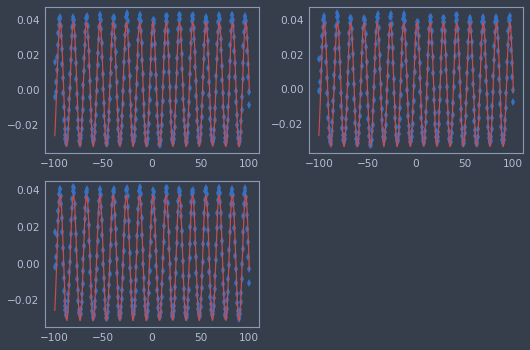

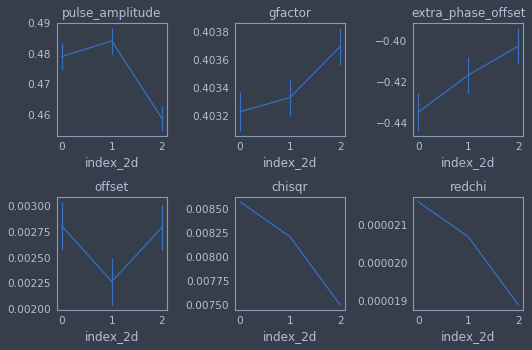

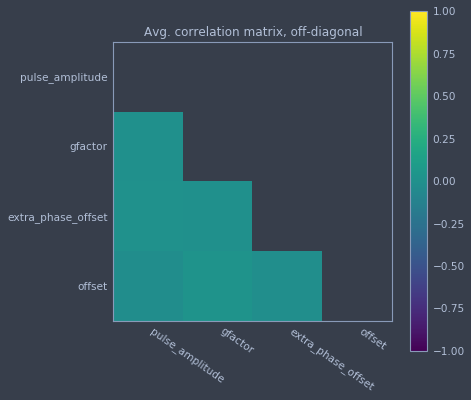

In [24]:
from eda.analysis.dataframe_processing \
    import df_minimize_fcn_on_datasets

df = full_dataframe
residuals_fcn = trkr_decaying_cosine_residuals
fit_params = fit_params
independent_vars_columns = ["probe_delay", "b_external"]
measured_data_column = measured_value_column
column_aggregation_dict = {}  # needed to keep cols w/ non-const values
keep_const_columns = True

output_fit_results_dataframe_filename = "fit_results_dataframe.csv"
output_fit_minimize_results_filename = "fit_minimize_results.pickle"
output_fit_vs_data_image_filename = "fit_results_fit_vs_data.png"
output_fit_params_image_filename = "fit_results_fit_params.png"
output_fit_covariances_image_filename = "fit_results_covariances.png"

# Fit!
minimize_results, results_df = \
    df_minimize_fcn_on_datasets(
        df, residuals_fcn, fit_params,
        independent_vars_columns,
        measured_data_column,
        column_aggregation_dict=column_aggregation_dict,  # keywords only!
#        method='nelder',
        keep_const_columns=keep_const_columns,
    )

# add minimizer result attributes to results_df
attributes_to_add = ['chisqr', 'redchi']
for attribute in attributes_to_add:
    attribute_list = []
    for result in minimize_results:
        attribute_list.append(getattr(result, attribute))
    results_df[attribute] = attribute_list

# Display fit params dataframe & save to file
with open(output_fit_results_dataframe_filename, 'w') as f:
    results_df.to_csv(f, sep='\t')
with open(output_fit_minimize_results_filename, 'wb') as f:
    pickle.dump(minimize_results, f)
display(results_df.head(5))

# plot fits
ncols = 2
nplots = len(minimize_results)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for result_index in list(range(nplots)):
    ax = plt.subplot(nrows, ncols, result_index + 1)
    result = minimize_results[result_index]
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coordinate_column]
    yvals = df.loc[dataset_index][measured_data_column]
    indep_vars_vecs = [df.loc[dataset_index][colname]
                       for colname in independent_vars_columns]
    fit_yvals = residuals_fcn(result.params, *indep_vars_vecs)
    ax.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax.plot(xvals, fit_yvals, 'r')
    plt.tight_layout()
plt.savefig(output_fit_vs_data_image_filename,
            bbox_inches='tight',
            transparent=False)

# plot params
params_to_plot_list = result.var_names + attributes_to_add
ncols = 3
nplots = len(params_to_plot_list)
nrows = np.int(np.ceil(nplots / ncols))
plt.figure(figsize=(FIG_SIZE_MULT * 3, FIG_SIZE_MULT * nrows))
for ind, param in enumerate(params_to_plot_list):
    ax = plt.subplot(nrows, ncols, ind + 1)
    if (param + '_error') in list(results_df):
        ax.errorbar(x=results_df.index.get_level_values(-1),
                    y=results_df[param],
                    yerr=results_df[param + '_error'])
    else:
        ax.plot(results_df.index.get_level_values(-1),
                results_df[param].values)
    plt.xlabel(results_df.index.names[-1])
    plt.tight_layout()
    plt.title(param)
plt.savefig(output_fit_params_image_filename,
            bbox_inches='tight',
            transparent=False)

# Plot the avg. covariance matrix
corr_mats = []
for result in minimize_results:
    covar = result.covar
    oostd = np.diagflat([1.0 / param.stderr
                         for param in list(result.params.values())
                         if param.name in result.var_names
                         if param.stderr != 0])
    corr = np.dot(np.dot(oostd, result.covar), oostd).astype(np.float)
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    corr[mask] = np.nan
    corr_mats.append(corr)
avgcorr = np.mean(corr_mats, axis=0)
plt.figure()
plt.imshow(avgcorr, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(result.nvarys), result.var_names,
           rotation=-35, ha='left')
plt.yticks(np.arange(result.nvarys), result.var_names)
plt.title('Avg. correlation matrix, off-diagonal')
plt.savefig(output_fit_covariances_image_filename,
            bbox_inches='tight',
            transparent=False)
plt.show()


----------------------------------------


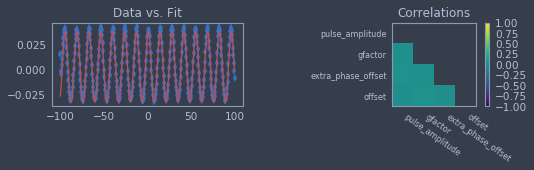

FIT #1
run_id: 0.0
index_2d: 0.0
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 401
    # variables        = 4
    chi-square         = 0.009
    reduced chi-square = 0.000
    Akaike info crit   = -4304.006
    Bayesian info crit = -4288.030
[[Variables]]
    pulse_amplitude:      0.47887258 +/- 0.004433 (0.93%) (init= 1)
    gfactor:              0.40322408 +/- 0.000138 (0.03%) (init= 0.4)
    spin_lifetime:        5000 (fixed)
    initial_phase:        0 (fixed)
    extra_phase_offset:  -0.43513821 +/- 0.009192 (2.11%) (init= 0)
    slope:                0 (fixed)
    offset:               0.00280151 +/- 0.000232 (8.29%) (init= 0)


None

----------------------------------------


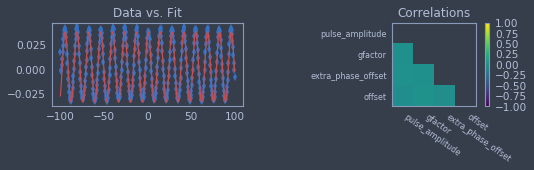

FIT #2
run_id: 0.0
index_2d: 1.0
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 401
    # variables        = 4
    chi-square         = 0.008
    reduced chi-square = 0.000
    Akaike info crit   = -4321.552
    Bayesian info crit = -4305.576
[[Variables]]
    pulse_amplitude:      0.48398046 +/- 0.004337 (0.90%) (init= 1)
    gfactor:              0.40332610 +/- 0.000134 (0.03%) (init= 0.4)
    spin_lifetime:        5000 (fixed)
    initial_phase:        0 (fixed)
    extra_phase_offset:  -0.41699131 +/- 0.008897 (2.13%) (init= 0)
    slope:                0 (fixed)
    offset:               0.00226155 +/- 0.000227 (10.05%) (init= 0)


None

----------------------------------------


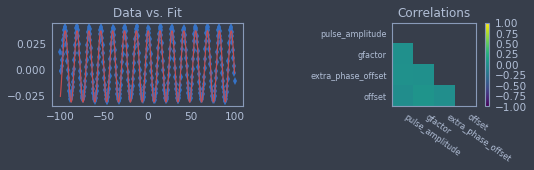

FIT #3
run_id: 0.0
index_2d: 2.0
[[Fit Statistics]]
    # function evals   = 28
    # data points      = 401
    # variables        = 4
    chi-square         = 0.007
    reduced chi-square = 0.000
    Akaike info crit   = -4358.195
    Bayesian info crit = -4342.219
[[Variables]]
    pulse_amplitude:      0.45861508 +/- 0.004144 (0.90%) (init= 1)
    gfactor:              0.40369193 +/- 0.000135 (0.03%) (init= 0.4)
    spin_lifetime:        5000 (fixed)
    initial_phase:        0 (fixed)
    extra_phase_offset:  -0.40281732 +/- 0.008968 (2.23%) (init= 0)
    slope:                0 (fixed)
    offset:               0.00278554 +/- 0.000217 (7.79%) (init= 0)


None

In [25]:
# DETAILED FIT REPORTS
for result_index, result in enumerate(minimize_results):
    print('----------------------------------------')
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False,
                                   figsize=(FIG_SIZE_MULT * 3,
                                            FIG_SIZE_MULT * 1))
    dataset_index = results_df.index[result_index]
    xvals = df.loc[dataset_index][scan_coordinate_column]
    yvals = df.loc[dataset_index][measured_data_column]
    indep_vars_vecs = [df.loc[dataset_index][colname]
                       for colname in independent_vars_columns]
    fit_yvals = residuals_fcn(result.params, *indep_vars_vecs)
    ax1.plot(xvals, yvals, 'bd', label='dataset {}'.format(result_index))
    ax1.plot(xvals, fit_yvals, 'r')
    ax1.set_title('Data vs. Fit')
    img = ax2.imshow(corr_mats[result_index], vmin=-1, vmax=1)
    fig.colorbar(img, ax=ax2)
    plt.xticks(np.arange(result.nvarys), result.var_names,
               rotation=-35, ha='left', fontsize=8)
    plt.yticks(np.arange(result.nvarys), result.var_names, fontsize=8)
    ax2.set_title('Correlations')
    plt.tight_layout()
    plt.show()
    print('FIT #{}'.format(result_index + 1))
    for col, val in zip(results_df.index.names,
                        results_df.index[result_index]):
        print('{}: {}'.format(col, val))
    display(report_fit(result))